# **Semantic Segmentation using PSP-Net with Efficient-Netb2 as Background with Keras and TensorFlow**

## **Installing Librarires**

In [ ]:
!pip install segmentation-models
!pip install keras==2.9.0
!pip install livelossplot
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [ ]:
%matplotlib inline

## **Importing Libraries**

In [ ]:
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from matplotlib import pyplot as plt
from keras import backend as K
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Concatenate
from keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu

Segmentation Models: using `keras` framework.


## **Unzip Data**

In [ ]:
!unzip '/content/A3_Dataset.zip' 

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

# **Loading the Dataset**

## **Load and Preprocess Train Images**

In [ ]:
Xsize = 384
Ysize = 384

#Capture training image info as a list
images_train = []
for dir_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_train"):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Ysize, Xsize))
        images_train.append(image)
       
#Capture mask/label info as a list
masks_training = [] 
for dir_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_train"):
    for mask_path in glob.glob(os.path.join(dir_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Ysize, Xsize)) 
        masks_training.append(mask)

images_train = np.array(images_train)      
masks_training = np.array(masks_training)


## **Load and Preprocess Test Images**

In [ ]:
Xsize = 384 
Ysize = 384

#Capture testing image info as a list
images_test = []
for dir_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_test"):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Ysize, Xsize))
        images_test.append(image)

#Convert list to array       
images_test = np.array(images_test)

#Capture mask/label info as a list
masks_test = [] 
for dir_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_test"):
    for mask_path in glob.glob(os.path.join(dir_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Ysize, Xsize))
        masks_test.append(mask)

#Convert list to array        
masks_test = np.array(masks_test)



## **Obtain Train and Test Data**

In [ ]:
input_train_mask = np.expand_dims(masks_training, axis=3)
X_train = images_train
y_train = input_train_mask
masks_test_input = np.expand_dims(masks_test, axis=3)
X_test = images_test
y_test = masks_test_input

In [ ]:
X_test.shape

(101, 384, 384, 3)

## **OHE**

In [ ]:
n_classes=12 #Number of classes for segmentation
from tensorflow.keras.utils import to_categorical
masks_training_category = to_categorical(y_train, num_classes=n_classes)
training_cat_y = masks_training_category.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
masks_test_category = to_categorical(y_test, num_classes=n_classes)
testing_cat_y = masks_test_category.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [ ]:
testing_cat_y.shape

(101, 384, 384, 12)

## **Display Data**

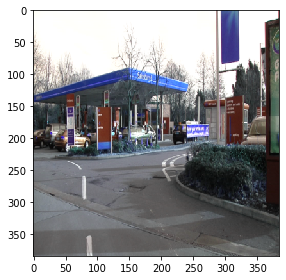

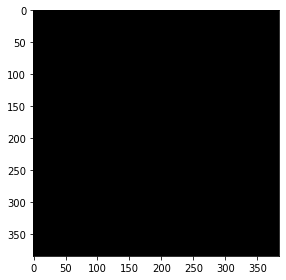

In [ ]:
def show(img):
  io.imshow(img)
  plt.show()

show(X_train[5])
show(np.argmax(y_train[5],axis=2))

## **PSP-Net with Efficient-Netb2 as Background**

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
#setting the framework
sm.set_framework('tf.keras')

## **Model Compialtion**

In [ ]:
BACKBONE1 = 'efficientnetb2'
Batch_size=10
LR=0.001
epochs=25
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train = preprocess_input1(X_train)
X_test = preprocess_input1(X_test)
activation='softmax'
# define model(Transfer Learning)
model1 = sm.PSPNet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model1.compile(optim, total_loss, metrics)
# compile keras model with defined optimozer, loss and metrics
#model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",metrics])

#Check the model summary
print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 192, 192, 32  128         ['stem_conv[0][0]']              
                                )                                                             

In [ ]:
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Model Training and Saving**

In [ ]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
history1=model1.fit(X_train, 
          training_cat_y,
          batch_size=Batch_size, 
          epochs=epochs,
          verbose=1,callbacks = callbacks,
          validation_data=(X_test, testing_cat_y))

model1.save('efficientnetb2_backbone_pspnet.h5')

Epoch 1/25
37/37 [==============================] - 47s 568ms/step - loss: 0.6179 - iou_score: 0.3322 - f1-score: 0.4136 - val_loss: 0.6514 - val_iou_score: 0.3173 - val_f1-score: 0.3758 - lr: 0.0010
Epoch 2/25
37/37 [==============================] - 17s 462ms/step - loss: 0.4827 - iou_score: 0.4427 - f1-score: 0.5472 - val_loss: 0.5878 - val_iou_score: 0.3710 - val_f1-score: 0.4400 - lr: 0.0010
Epoch 3/25
37/37 [==============================] - 17s 470ms/step - loss: 0.4264 - iou_score: 0.4893 - f1-score: 0.6027 - val_loss: 0.4144 - val_iou_score: 0.4993 - val_f1-score: 0.6085 - lr: 0.0010
Epoch 4/25
37/37 [==============================] - 18s 475ms/step - loss: 0.3918 - iou_score: 0.5205 - f1-score: 0.6356 - val_loss: 0.3974 - val_iou_score: 0.5181 - val_f1-score: 0.6242 - lr: 0.0010
Epoch 5/25
37/37 [==============================] - 17s 473ms/step - loss: 0.3724 - iou_score: 0.5382 - f1-score: 0.6544 - val_loss: 0.3634 - val_iou_score: 0.5444 - val_f1-score: 0.6561 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# **Quantitative Performance Measures**

## **Loss Curve**

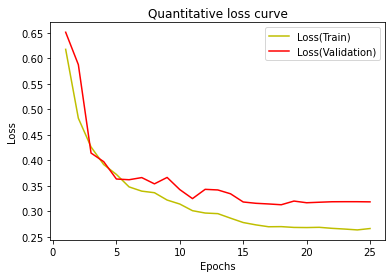

In [ ]:
#plotting the cross entropy loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Loss(Train)')
plt.plot(epochs, val_loss, 'r', label='Loss(Validation)')
plt.title('Quantitative loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **IOU Curve**

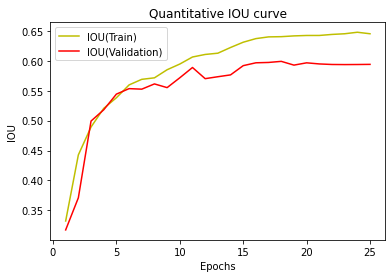

In [ ]:
iou_score = history1.history['iou_score']
val_iou_score = history1.history['val_iou_score']
plt.plot(epochs, iou_score, 'y', label='IOU(Train)')
plt.plot(epochs, val_iou_score, 'r', label='IOU(Validation)')
plt.title('Quantitative IOU curve')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

## **F1 Score**

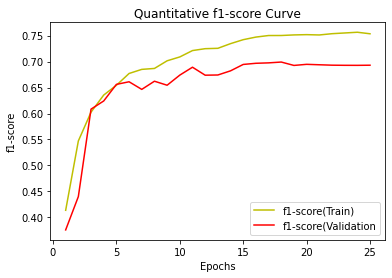

In [ ]:
#plotting the f1 score
f1_score = history1.history['f1-score']
val_f1_score = history1.history['val_f1-score']
plt.plot(epochs, f1_score, 'y', label='f1-score(Train)')
plt.plot(epochs, val_f1_score, 'r', label='f1-score(Validation')
plt.title('Quantitative f1-score Curve')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model1_load = load_model('/content/inceptionv3_backbone_pspnet.h5', compile=False)

In [ ]:
y_pred1=model1_load.predict(X_test)
y_pred1_argmax=np.argmax(y_pred1, axis=3)